<a href="https://colab.research.google.com/github/sradicwebster/RL_implementation/blob/master/dqn_cartpole.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import numpy as np
from tqdm import tqdm
import gym
import random
import time
import matplotlib.pyplot as plt
from collections import namedtuple

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

# if gpu is to be used
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

env = gym.make('CartPole-v0')

# Get size of observation space
obs_size = env.observation_space.shape[0]
print(f'Observation space: {obs_size}')
# Cart Position, Cart Velocity, Pole Angle, Pole Angular Velocity 

# Get number of actions from gym action space
n_actions = env.action_space.n
print(f'Action space: {n_actions}')
# Left, Right

Observation space: 4
Action space: 2


In [2]:
Transition = namedtuple('Transition', ('state', 'action', 'next_state', 'reward', 'terminal'))

class ReplayMemory():

    def __init__(self, capacity):
        self.capacity = capacity
        self.memory = []
        self.position = 0

    def store(self, *args):
        """Saves a transition."""
        if len(self.memory) < self.capacity:
            self.memory.append(None)
        self.memory[self.position] = Transition(*args)
        self.position = (self.position + 1) % self.capacity

    def sample(self, batch_size):
        return random.sample(self.memory, batch_size)

    def __len__(self): # this needed??
        return len(self.memory)

    
class Qnetwork(nn.Module):
    def __init__(self):
        super(Qnetwork, self).__init__()
        self.fc1 = nn.Linear(obs_size, 64)
        self.fc2 = nn.Linear(64, 32)
        self.fc3 = nn.Linear(32, n_actions)
            
    #define the forward function, and the backward function (where gradients are computed)
    # is automatically defined for you using autograd
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

net = Qnetwork()
params = list(net.parameters())
print([params[i].shape for i in range(len(params))])

[torch.Size([64, 4]), torch.Size([64]), torch.Size([32, 64]), torch.Size([32]), torch.Size([2, 32]), torch.Size([2])]


In [3]:
def epsilon_greedy_action(state):
    
    global steps_done
    epsilon = EPS_END + (EPS_START - EPS_END) * np.exp(-1. * steps_done / EPS_DECAY)
    steps_done += 1
    
    if np.random.rand() < epsilon:
        return env.action_space.sample()
    else:
        with torch.no_grad():
            current_q = policy_net.forward(torch.from_numpy(state).float().to(device))
            return torch.argmax(current_q).item()
        
def forward_prop(network, state):
    return network.forward(torch.from_numpy(state).float().to(device))

def optimize_model():
    if len(memory) < BATCH_SIZE:
        return

    minibatch = memory.sample(BATCH_SIZE)
    targets = []
    current_qs = []
    for transition in minibatch:

        if transition.terminal is True:
            target = torch.tensor(transition.reward, device=device)
        else:
            target = transition.reward + GAMMA * forward_prop(target_net, transition.next_state).max()

        current_q = forward_prop(policy_net, state)[transition.action]

        targets.append(target)
        current_qs.append(current_q)

    loss = loss_fn(torch.stack(current_qs).to(device), torch.stack(targets).to(device))

    optimizer.zero_grad()
    loss.backward()
    for param in policy_net.parameters():
        param.grad.data.clamp_(-1, 1)
    optimizer.step()
    
    
def plot_durations():
    plt.figure(2)
    plt.clf()
    durations_t = torch.tensor(episode_rewards, dtype=torch.float)
    plt.title('Training...')
    plt.xlabel('Episode')
    plt.ylabel('Duration')
    plt.plot(durations_t.numpy())
    # Take 50 episode averages and plot them too
    if len(durations_t) >= 50:
        means = durations_t.unfold(0, 50, 1).mean(1).view(-1)
        means = torch.cat((torch.zeros(49), means))
        plt.plot(means.numpy())



  9%|▊         | 86/1000 [03:50<40:46,  2.68s/it]

KeyboardInterrupt: ignored

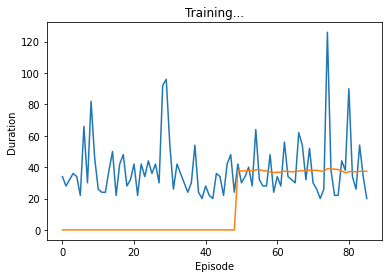

In [4]:
BATCH_SIZE = 128
GAMMA = 0.99
LEARNING_RATE = 5e-4
UPDATE_TARGET = 10 # steps between target network updates (C parameter)
# epsilon 
EPS_START = 0.9
EPS_END = 0.1 #0.05
EPS_DECAY = 200

num_episodes = 1000

# initialise parameterised action-value functions
policy_net = Qnetwork().to(device) # policy net gets updated
target_net = Qnetwork().to(device) # target net updated set to equal policy net every UPDATE_TARGET steps

target_net.load_state_dict(policy_net.state_dict())
target_net.eval()

gpu = torch.device('cuda:0')

optimizer = optim.Adam(policy_net.parameters(), lr=LEARNING_RATE)
memory = ReplayMemory(2000) # 10000 default (D parameter)
loss_fn = torch.nn.MSELoss() # Huber loss instead?

episode_rewards = []

for episode in tqdm(range(num_episodes)):
    
    # reset step count
    steps_done = 0
    losses = []
    
    # get start state from env
    state = env.reset() 
    
    terminal = False
    while terminal is False:
        
        # choose next action
        action = epsilon_greedy_action(state)
        
        # take next step and get reward from env
        next_state, reward, terminal, _ = env.step(action)
        
        # store in memory
        memory.store(state, action, next_state, reward, terminal)
        
        # updates
        steps_done += 1
        state = next_state
       
        # Perform one step of the optimization (on the target network)
        optimize_model()
        
        if terminal:
            episode_rewards.append(steps_done)
            plot_durations()
            break

    # Update the target network, copying all weights and biases in DQN
    if episode % UPDATE_TARGET == 0:
        target_net.load_state_dict(policy_net.state_dict())
    


